# Big Data Project

## Contents

1. Loading datasets
2. Data cleaning and feature selection
3. Exploratory Data Analysis
4. Hypothesis I: Football matches
5. Hypothesis II:
6. Hypothesis III:

## Packages
Importing all necessary packages to run the notebooks

In [49]:
# packages for data manipulation
import numpy as np
import pandas as pd
import pickle

from pathlib import Path

import regex as re

import scipy.stats as stats
from scipy.stats import pearsonr

# packages for web scraping
import requests
import csv
from bs4 import BeautifulSoup
import datetime

#packages for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori

## Directory navigation and creation
Creating pathlib.Path objects for cross-platform navigation

In [21]:
# creating Path object for current working directory
directory = Path('./')
# creating Path object for additional data directory
additional_directory = directory / 'additional_data'
# create new directory for additional data
Path(additional_directory).mkdir(exist_ok=True)

In [22]:
# defining the directory to original data
directory = Path('./data/')
additional_directory = Path('./additional_data')

# list the .csv files for the project
for file in directory.glob('*.csv'):
    print(file)

data/vehicles2019.csv
data/accidents2019.csv
data/casualties2019.csv


## Reading datasets
Reading in the original three datasets

In [23]:
# reading in .csv files to dataframes
vehicles = pd.read_csv(directory / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(directory / 'casualties2019.csv', dtype={'Accident_Index': str})
accidents = pd.read_csv(directory / 'accidents2019.csv', dtype={'Accident_Index': str,
                                                                'LSOA_of_Accident_Location': str})

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)
lower_columns(accidents)

accidents.head(5)

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,...,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,lsoa_of_accident_location
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,...,0,5,1,1,1,0,0,1,3,E01004762
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,15/01/2019,...,-1,-1,4,1,1,0,0,1,3,E01003117
2,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000943
3,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000973
4,2019010155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000546


In [24]:
# checking features with NaN values
accidents.isnull().sum()

accident_index                                    0
location_easting_osgr                            28
location_northing_osgr                           28
longitude                                        28
latitude                                         28
police_force                                      0
accident_severity                                 0
number_of_vehicles                                0
number_of_casualties                              0
date                                              0
day_of_week                                       0
time                                             63
local_authority_(district)                        0
local_authority_(highway)                         0
1st_road_class                                    0
1st_road_number                                   0
road_type                                         0
speed_limit                                       0
junction_detail                                   0
junction_con

## Data Cleaning and Feature Creation
1. latitude and longitude imputation
    
    
    SOURCE: https://simplemaps.com/data/gb-cities
    
2. Datetime formatting

    SOURCE: https://www.sunrise-and-sunset.com/en/sun/united-kingdom/london/2019/

In [25]:
# import the local_authority.csv file of local_athority data that came with the original accident data
local_authorities = pd.read_csv(additional_directory / 'local_authority.csv')
local_authorities.columns = ['local_authority_(district)', 'district']

# merge the accidents dataframe with the local_authorities dataframe on 'local_authority_(district)'
accidents = pd.merge(accidents, local_authorities, on=['local_authority_(district)'])

accidents[['longitude', 'latitude', 'local_authority_(district)', 'district']]
accidents.district = accidents.district.str.lower().str.strip()

In [26]:
# import the latitude, longitude and admin_name columns of the city_coords.csv file
cities = pd.read_csv(additional_directory / 'city_coords.csv', usecols=['lat', 'lng', 'admin_name'])
cities.columns = ['latitude_new', 'longitude_new', 'district']
cities.district = cities.district.str.lower()
cities

,latitude_new,longitude_new,district
0,51.5072,-0.1275,"london, city of"
1,52.4800,-1.9025,birmingham
2,53.4794,-2.2453,manchester
3,53.7997,-1.5492,leeds
4,55.0077,-1.6578,newcastle upon tyne
...,...,...,...
2675,53.4960,-1.4120,rotherham
2676,57.2670,-2.1920,aberdeenshire
2677,51.6116,-3.5842,bridgend
2678,51.1536,1.3714,kent


In [27]:
# print the 'district' of instances with missing coordinate data
missing_districts = accidents[accidents.longitude.isnull()]['district']
print(f"Districts with missing coordinate data: {set(missing_districts)}")
len(missing_districts)
missing_districts.value_counts()

Districts with missing coordinate data: {'harrogate', 'scarborough', 'hambleton', 'ryedale', 'wirral', 'selby', 'warrington', 'wigan', 'cheshire east', 'adur', 'west dorset', 'medway', 'cheshire west and chester', 'flintshire', 'wakefield', 'rugby', 'north east lincolnshire', 'powys', 'cardiff', 'liverpool'}


hambleton                    4
harrogate                    3
selby                        3
ryedale                      2
north east lincolnshire      1
cardiff                      1
flintshire                   1
west dorset                  1
adur                         1
medway                       1
rugby                        1
wigan                        1
wakefield                    1
wirral                       1
scarborough                  1
warrington                   1
cheshire west and chester    1
cheshire east                1
liverpool                    1
powys                        1
Name: district, dtype: int64

In [28]:
# determine the 'districts' with missing coordinate data in our data set that are not in the city_coords.csv file
set(missing_districts) - set(cities.district)

{'adur',
 'hambleton',
 'harrogate',
 'rugby',
 'ryedale',
 'scarborough',
 'selby',
 'west dorset'}

In [29]:
# manually add these districts to the cities df of the city_coords.csv file
manual_additions = pd.DataFrame(np.array([50.8348, 0.3101, 'adur', 
                                          54.2959, 1.3135, 'hambleton',
                                          53.9921, 1.5418, 'harrogate',
                                          52.3709, 1.2650, 'rugby',
                                          54.1698, 0.7282, 'ryedale', 
                                          54.2831, 0.3998, 'scarborough',
                                          53.7835, 1.0672, 'selby', 
                                          50.7755, 2.5817, 'west dorset']).reshape(-1, 3))
manual_additions.columns = ['latitude_new', 'longitude_new', 'district']
cities = pd.concat([cities, manual_additions], axis=0)

cities.shape

(2688, 3)

In [30]:
# determine the 'districts' with missing coordinate data in our data set that are not in the city_coords.csv file
set(missing_districts) - set(cities.district)

set()

In [31]:
# determine the average coordinates for locations in this district in the cities df
cities = cities.groupby('district').median()

# inner-join the accidents dataframe with the cities dataframe on the 'district' column
accidents = accidents.merge(cities, on='district')

In [32]:
# impute the missing longitude and latitude values with the new longitude and latitude values from the cities dataframe
accidents.loc[accidents.longitude.isnull(), 'longitude'] = accidents.loc[accidents.longitude.isnull(), 'longitude_new']
accidents.loc[accidents.latitude.isnull(), 'latitude'] = accidents.loc[accidents.latitude.isnull(), 'latitude_new']

In [33]:
# drop the columns used for this imputation, as well as the osgr coordinates (replicated information)
accidents = accidents.drop(['location_easting_osgr', 'location_northing_osgr',
                            'latitude_new', 'longitude_new'], axis=1)
accidents.isnull().sum()

accident_index                                    0
longitude                                         0
latitude                                          0
police_force                                      0
accident_severity                                 0
number_of_vehicles                                0
number_of_casualties                              0
date                                              0
day_of_week                                       0
time                                             59
local_authority_(district)                        0
local_authority_(highway)                         0
1st_road_class                                    0
1st_road_number                                   0
road_type                                         0
speed_limit                                       0
junction_detail                                   0
junction_control                                  0
2nd_road_class                                    0
2nd_road_num

### Datetime formatting

In [34]:
# create 'converted_date' and 'converted_column' features for manipulation of dates and times
accidents['converted_date'] = pd.to_datetime(accidents['date'],
                                              format='%d/%m/%Y')
accidents['converted_time'] = pd.to_datetime(accidents['time'],
                                             errors='coerce',
                                             format='%H:%M').dt.time

print(f'converted_date dtype: {accidents["converted_date"].dtype}')
print(f'converted_time dtype: {accidents["converted_time"].dtype}')
print(type(accidents['converted_time'][0]))

accidents[['converted_date', 'converted_time']]

converted_date dtype: datetime64[ns]
converted_time dtype: object
<class 'datetime.time'>


,converted_date,converted_time
0,2019-01-15,21:45:00
1,2019-01-02,07:10:00
2,2019-01-02,12:10:00
3,2019-01-04,01:30:00
4,2019-01-04,13:45:00
...,...,...
73315,2019-05-18,01:00:00
73316,2019-05-30,08:46:00
73317,2019-06-21,15:30:00
73318,2019-06-29,14:10:00


So the converted_date column has a dtype of datetime64[ns]
and the converted_time column has a dtype of object consisting of datetime.time elements

In [35]:
# checking the number of values that are NaN
accidents.isnull().sum()

accident_index                                    0
longitude                                         0
latitude                                          0
police_force                                      0
accident_severity                                 0
number_of_vehicles                                0
number_of_casualties                              0
date                                              0
day_of_week                                       0
time                                             59
local_authority_(district)                        0
local_authority_(highway)                         0
1st_road_class                                    0
1st_road_number                                   0
road_type                                         0
speed_limit                                       0
junction_detail                                   0
junction_control                                  0
2nd_road_class                                    0
2nd_road_num

### Cleaning the time column

In [36]:
# rows with time column == NaT
accidents[accidents['converted_time'].isnull()][['converted_date',
                                                 'converted_time',
                                                'light_conditions']]

,converted_date,converted_time,light_conditions
756,2019-08-30,NaT,4
2409,2019-05-24,NaT,7
2410,2019-05-27,NaT,1
3061,2019-02-17,NaT,4
3301,2019-05-26,NaT,7
3326,2019-05-27,NaT,1
3644,2019-07-09,NaT,1
3816,2019-12-08,NaT,7
4415,2019-08-10,NaT,4
4628,2019-11-01,NaT,1


### Checking for correlation between time and light_conditions

In [37]:
light = accidents.loc[accidents.converted_time.notnull(), ['converted_time', 'light_conditions']]

# adding dummy date to converted-time column for manipulation
date = str(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d').date())
light['converted_time'] = pd.to_datetime(date + " " + light.converted_time.astype(str))

# do one-hot encoding for the light_conditions column
light = pd.concat([light, pd.get_dummies(light.light_conditions)], axis=1).drop(['light_conditions', -1], axis=1)
#srss['average_time'] = srss.apply(lambda row: find_avg_time(row.sunrise, row.sunset), axis=1)
light.columns = ['time', 'daylight', 'lights_lit',
                 'lights_unlit', 'no_lighting', 'unknown']

# group the dataframe by hour of day
light.groupby(pd.Grouper(key='time', freq='H')).sum()

,daylight,lights_lit,lights_unlit,no_lighting,unknown
time,,,,,
2018-01-01 00:00:00,76.0,897.0,19.0,145.0,74.0
2018-01-01 01:00:00,54.0,611.0,21.0,110.0,54.0
2018-01-01 02:00:00,62.0,449.0,6.0,87.0,37.0
2018-01-01 03:00:00,52.0,377.0,8.0,58.0,39.0
2018-01-01 04:00:00,109.0,311.0,10.0,49.0,35.0
2018-01-01 05:00:00,257.0,315.0,9.0,78.0,45.0
2018-01-01 06:00:00,804.0,417.0,19.0,85.0,57.0
2018-01-01 07:00:00,2743.0,328.0,16.0,72.0,76.0
2018-01-01 08:00:00,4883.0,40.0,11.0,19.0,13.0


In [38]:
# read in sunrise_sunset.csv as dataframe
srss = pd.read_csv(additional_directory / 'sunrise_sunset.csv')

# string formatting
srss['sunrise'] = srss['sunrise'] + ':00'
srss['sunset'] = srss['sunset'] + ':00'
srss['day_length'] = srss['day_length'] + ':00'
# create converted_date feature as np.datetime64 dtype
srss['converted_date'] = pd.to_datetime(srss['date'])
# drop original date column
srss = srss.drop(['date'], axis=1)
# convert sunrise and sunset to np.timedelta64 dtype
srss['sunrise'] = pd.to_timedelta(srss['sunrise'])
srss['sunset'] = pd.to_timedelta(srss['sunset'])


def find_avg_time(first_time, second_time):
    """
    Description:
        Given two times, find the average time between them
        (t1 + t2) / 2
    """
    time1_s = first_time.total_seconds()
    time2_s = second_time.total_seconds()
    time = (time1_s + time2_s) / 2 - 3600
    return datetime.datetime.fromtimestamp(time).strftime("%H:%M")
    
# create average time column using the find_avg_time function
srss['average_time'] = srss.apply(lambda row: find_avg_time(row.sunrise, row.sunset), axis=1)

In [39]:
srss

,sunrise,sunset,day_length,converted_date,average_time
0,0 days 08:06:00,0 days 16:01:00,07:54:00,2019-01-01,12:03
1,0 days 08:06:00,0 days 16:02:00,07:55:00,2019-01-02,12:04
2,0 days 08:06:00,0 days 16:03:00,07:56:00,2019-01-03,12:04
3,0 days 08:06:00,0 days 16:04:00,07:58:00,2019-01-04,12:05
4,0 days 08:06:00,0 days 16:05:00,07:59:00,2019-01-05,12:05
...,...,...,...,...,...
360,0 days 08:06:00,0 days 15:56:00,07:49:00,2019-12-27,12:01
361,0 days 08:06:00,0 days 15:57:00,07:50:00,2019-12-28,12:01
362,0 days 08:06:00,0 days 15:58:00,07:51:00,2019-12-29,12:02
363,0 days 08:06:00,0 days 15:59:00,07:52:00,2019-12-30,12:02


In [40]:
# drop columns which are not needed
srss = srss.drop(['sunrise', 'sunset', 'day_length'], axis=1)
# merge useful columns of srss to accidents dataframe on converted_date column
accidents = pd.merge(accidents, srss, on=['converted_date'])

accidents.columns

Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'date', 'day_of_week', 'time', 'local_authority_(district)',
       'local_authority_(highway)', '1st_road_class', '1st_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location', 'district', 'converted_date',
       'converted_time', 'average_time'],
      dtype='object')

In [41]:
# mask for values with null values in converted_time column
missing_time_mask = accidents["converted_time"].isnull()

# impute missing times with average time 
accidents.loc[missing_time_mask, 'converted_time'] = accidents.loc[missing_time_mask, 'average_time']

accidents = accidents.drop(['average_time'], axis=1)
accidents.columns

Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'date', 'day_of_week', 'time', 'local_authority_(district)',
       'local_authority_(highway)', '1st_road_class', '1st_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location', 'district', 'converted_date',
       'converted_time'],
      dtype='object')

In [42]:
# create a single 'datetime' feature in ISO 8601 format
# using numpy.datetime64 object

accidents['datetime'] = pd.to_datetime(accidents['converted_date'].astype(str) + " " + accidents['converted_time'].astype(str),
               format = '%Y-%m-%d %H:%M:%S')

# dropping the original date and time columns
accidents = accidents.drop(['date', 'time'], axis=1)
accidents['datetime']

0       2019-01-15 21:45:00
1       2019-01-15 08:42:00
2       2019-01-15 07:08:00
3       2019-01-15 21:05:00
4       2019-01-15 16:10:00
                ...        
73315   2019-03-18 16:10:00
73316   2019-03-18 10:10:00
73317   2019-03-18 12:04:00
73318   2019-03-18 01:00:00
73319   2019-03-18 16:40:00
Name: datetime, Length: 73320, dtype: datetime64[ns]

In [43]:
# time column is now cleaned
accidents.isnull().sum()

accident_index                                    0
longitude                                         0
latitude                                          0
police_force                                      0
accident_severity                                 0
number_of_vehicles                                0
number_of_casualties                              0
day_of_week                                       0
local_authority_(district)                        0
local_authority_(highway)                         0
1st_road_class                                    0
1st_road_number                                   0
road_type                                         0
speed_limit                                       0
junction_detail                                   0
junction_control                                  0
2nd_road_class                                    0
2nd_road_number                                   0
pedestrian_crossing-human_control                 0
pedestrian_c

In [44]:
# create a decimal time column using the time component of 'converted_time'
def convert_to_decimal(df, new_col, original_col='datetime',):
    """Convert datetime.time value to decimal"""
    df[new_col] = df[original_col].dt.hour + df[original_col].dt.minute / 60
    
# create decimal_time column
convert_to_decimal(accidents, 'decimal_time', 'datetime')

accidents.loc[:, ['datetime', 'decimal_time']].head(5)

,datetime,decimal_time
0,2019-01-15 21:45:00,21.750000
1,2019-01-15 08:42:00,8.700000
2,2019-01-15 07:08:00,7.133333
3,2019-01-15 21:05:00,21.083333
4,2019-01-15 16:10:00,16.166667


In [45]:
def to_day_of_year(datetime_val):
    """Return the day of the year for a given datetime.date value"""
    return datetime_val.dayofyear

accidents['day_of_year'] = accidents['datetime'].apply(to_day_of_year)
accidents['day_of_year'] = accidents['day_of_year'].fillna(-10)
accidents['day_of_year'] = accidents['day_of_year'].astype('int32')

# 10 randomly sampled columns
accidents.loc[:, ['datetime', 'day_of_year']].sample(10)

,datetime,day_of_year
32565,2019-07-03 08:00:00,184
27390,2019-06-07 18:20:00,158
24892,2019-05-25 16:20:00,145
36869,2019-07-24 11:07:00,205
60631,2019-11-20 18:30:00,324
27014,2019-06-05 13:28:00,156
55577,2019-10-26 19:35:00,299
59874,2019-11-16 17:15:00,320
20551,2019-04-28 12:15:00,118
21289,2019-05-03 22:30:00,123


In [ ]:
accidents.to_pickle('accidents_cleaned.pkl')

## Exploratory Data Analysis

[Text(0.5, 0, 'Time of day'),
 Text(0, 0.5, 'Number of accidents'),
 Text(0.5, 1.0, 'Total number of accidents by time of day.')]

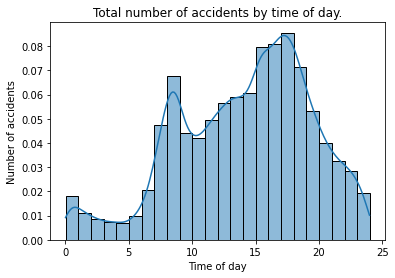

In [47]:
ax = sns.histplot(data=accidents,
             x='decimal_time',
             binwidth=1,
             kde=True,
             stat='density')
ax.set(xlabel='Time of day',
       ylabel='Number of accidents',
       title='Total number of accidents by time of day.')

[<matplotlib.axis.XTick object at 0x290da6c20>, <matplotlib.axis.XTick object at 0x290da6bf0>, <matplotlib.axis.XTick object at 0x290db79d0>, <matplotlib.axis.XTick object at 0x290e20490>, <matplotlib.axis.XTick object at 0x290e20be0>, <matplotlib.axis.XTick object at 0x290e21330>, <matplotlib.axis.XTick object at 0x290e21a80>, <matplotlib.axis.XTick object at 0x290e221d0>, <matplotlib.axis.XTick object at 0x290e21b40>]


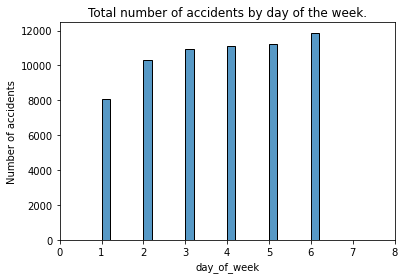

In [48]:
days = ['Mon', 'Tue', 'Wed',
        'Thu', 'Fri', 'Sat',
        'Sun']

ax = sns.histplot(data=accidents,
             x='day_of_week',
             binwidth=.2)
ax.set(ylabel='Number of accidents',
       xlim=(0, 8),
       title='Total number of accidents by day of the week.')

print(ax.xaxis.get_major_ticks())

In [32]:
accidents.day_of_week.value_counts()

6    11868
5    11252
4    11085
3    10939
2    10326
7     9775
1     8075
Name: day_of_week, dtype: int64

# Hypothesis: 
## More accidents at football stadiums on days of football matches

### Test case:

In [33]:
def sphere_distance(s_lat, s_lng, e_lat, e_lng):
    R = 6373.0
    
    s_lat = s_lat*np.pi/180
    s_lng = np.deg2rad(s_lng)
    e_lat = np.deg2rad(e_lat)
    e_lng = np.deg2rad(e_lng)
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    return 2 * R * np.arcsin(np.sqrt(d))

In [34]:
# coordinates for Old Trafford football stadium in Manchester
manc = [53.457831502, -2.288165514]

In [35]:
acc_manc = accidents

# create feature of the distance (in km) of an accident to Old Trafford
acc_manc['dist_from_manc'] = sphere_distance(manc[0], manc[1], acc_manc['latitude'], acc_manc['longitude'])

# filter for those accidents within 5km radius
distance_mask = acc_manc.dist_from_manc < 5
acc_manc = acc_manc[distance_mask]
# filter for Sunday
sunday_mask = acc_manc['day_of_week'] == 1
sunday_manc = acc_manc[sunday_mask]

# group by day and count number of accidents
sundays = sunday_manc.groupby('converted_date')['accident_index'].count()

zscores = stats.zscore(sundays)
zscores['2019-02-24']

sundays.mean()

1.7692307692307692

The value of accidents on the Sunday of the football match is 1.3 standard deviations away from the average. This deserves further investigation.

In [36]:
football = pd.read_csv('additional_data/football_stats.csv')
football['datetime'] = pd.to_datetime(football['datetime'])
football['converted_date'] = football['datetime'].dt.date

acc_i = accidents.copy()
football = football.sort_values('day_of_year')
acc_i = acc_i.drop('datetime', axis=1)
football = football.drop('datetime', axis=1)

In [37]:
zscores_list = []
for i in range(football.shape[0]):
    
    coordinates = [football.loc[i, 'latitude'], football.loc[i,'longitude']]
    football_day = football.loc[i, 'day_of_year']
    football_day_of_week = football.loc[i, 'day_of_week']
    football_stadium = football.loc[i, 'stadium_name']
    
    acc_i = accidents.copy()
    
    # add distance from stadium as a feature
    acc_i['dist_from_stadium'] = sphere_distance(coordinates[0], coordinates[1],
                                                 acc_i['latitude'], acc_i['longitude'])

    # filter for those accidents within 5km radius of the stadium
    distance_mask = acc_i['dist_from_stadium'] < 10
    # filter for that day of the week
    day_of_week_mask = acc_i['day_of_week'] == football_day_of_week

    final = acc_i[distance_mask & day_of_week_mask]
    

    final = final.groupby('day_of_year')['accident_index'].count()
    
    zscores = stats.zscore(final)
    mean = final.mean()
    
    if football_day in zscores.index:
        zscore = zscores[football_day]
        accidents_on_day = final[football_day]
    else:
        zscore = 0
        accidents_on_day = 0
    
    info = {
        'Day of match': football_day,
        'Stadium': football_stadium,
        'Accidents on day of match': accidents_on_day,
        'Mean # Accidents in area': mean,
        'z_score': zscore
    }
    
        
    zscores_list.append(info)

In [38]:
a = pd.DataFrame(zscores_list)
a

,Day of match,Stadium,Accidents on day of match,Mean # Accidents in area,z_score
0,1,Goodison Park,3,4.264151,-0.670671
1,13,Goodison Park,4,3.080000,0.665062
2,33,Goodison Park,1,3.230769,-1.274802
3,37,Goodison Park,3,4.211538,-0.676716
4,62,Goodison Park,3,3.080000,-0.057831
...,...,...,...,...,...
121,93,Tottenham Hotspur,18,17.538462,0.104265
122,103,Tottenham Hotspur,15,17.038462,-0.411199
123,113,Tottenham Hotspur,19,16.773585,0.514289
124,117,Tottenham Hotspur,14,17.038462,-0.612919


In [39]:
a.describe()

,Day of match,Accidents on day of match,Mean # Accidents in area,z_score
count,126.000000,126.000000,126.000000,126.000000
mean,70.317460,7.420635,7.982430,-0.057616
std,40.084241,7.609839,7.215750,0.817756
min,1.000000,0.000000,1.000000,-2.123445
25%,33.250000,2.000000,2.069183,-0.658984
50%,68.000000,4.000000,4.239919,0.000000
75%,108.750000,14.000000,14.548077,0.359493
max,132.000000,29.000000,24.653846,2.885372


# Association Pattern Mining

In [ ]:
class AssociationRule:
    def __init__(self, df):
        self.df = df
    
    def apriori(self,
                min_support=0.5,
                use_colnames=False,
                max_len=None,
                verbose=0):
        """
        Uses the mlxtend.frequent_patterns.apriori algorithm
        """
        df = self.df.iloc[:, 1:]
        return apriori(df, min_support,
                       use_colnames, max_len, verbose)
        
    def support(self, Y, X):
        """
        Determine support for two items.
        Inputs:
            X: antecedent
            Y: consequent
        Returns:
            support value
        """
        if X not in self.df.columns:
            raise TypeError("Invalid antecedent.")
        elif Y not in self.df.columns:
            raise TypeError("Invalid consequent.")
        else:
            freq_XY = self.df.groupby(X)[Y].value_counts()[1][1]
            return freq_XY / self.df.shape[0]

    def confidence(self, Y, X):
        """
        Determine confidence for two items.
        Inputs:
            X: antecedent
            Y: consequent
        Returns:
            confidence value
        """
        if X not in self.df.columns:
            raise TypeError("Invalid antecedent.")
        elif Y not in self.df.columns:
            raise TypeError("Invalid consequent.")
        else:
            freq_X = self.df[X].value_counts()[1] / self.df.shape[0]
            return self.support(X, Y) / freq_X
        
    def lift(self, Y, X):
        """
        Determine the confidence for two items.
        Inputs:
            X: antecedent
            Y: consequent
        Returns:
            lift value
        """
        if X not in self.df.columns:
            raise TypeError("Invalid antecenent.")
        elif Y not in self.df.columns:
            raise TypeError("Invalid consequent.")
        else:
            freq_X = self.df[X].value_counts()[1] / self.df.shape[0]
            freq_Y = self.df[Y].value_counts()[1] / self.df.shape[0]
            return self.support(X, Y) / (freq_X * freq_Y)
        
        
    def report(self, Y, X):
        """
        Prints a short summary report.
        Inputs:
            X: antecedent
            Y: consequent
        """
        if X not in self.df.columns:
            raise TypeError("Invalid antecedent.")
        elif Y not in self.df.columns:
            raise TypeError("Invalid consequent.")
        else:
            sup = self.support(X, Y)
            conf = self.confidence(X, Y)
            title = f'{X} -> {Y}'
            print(title)
            print('-' * len(title))
            print(f'Support: {sup:.2f}%')
            print(f'Confidence: {conf:.2f}%')

How speed limit affects casualty rates

$$ \text{Speed Limit} \rightarrow \text{Accident Severity}$$

In [ ]:
apm_cols = ['accident_severity', 'speed_limit', 'weather_conditions']

one_hot = pd.DataFrame()

for col in te.columns:
    dummy = pd.get_dummies(test.loc[:, col], prefix=col)
    one_hot = pd.concat([one_hot, dummy], axis=1)
    
one_hot

In [ ]:
ar = AssociationRule(dummies)

min_support = 0.2

frequent_itemsets = ar.apriori(min_support=min_support, use_colnames=True)

In [ ]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets,
                          metric='lift',
                          min_threshold=0.5)
rules

In [ ]:
def adaptive_support(d):
    """
    Adaptive support algorithm (Hikmawati et al.)
    """
    n_transactions = d.shape[0]
    
    freq_items = d.sum(axis=0)
    n_items = d.shape[1]
    
    support = freq_items / n_items
    criteria = []
    utility = support * criteria
    total = utility.sum()
    avg_total = total / n_items
    min_threshold = avg_total / n_transactions
    print(freq_items)
    return min_threshold
    

adaptive_support(one_hot)

In [ ]:
one_hot

In [ ]:
supports = one_hot.sum(axis=0) / one_hot.shape[0]

## Workshop 4: Building Model

In [ ]:
accidents.isnull().sum()

In [ ]:
casualties

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif

In [ ]:
predictors = ['weather_conditions', 'speed_limit',
              'road_surface_conditions', 'light_conditions']

usethis = accidents.dropna()
usethis.reset_index(drop=True)

usethis = usethis.filter(predictors, axis=1)

wc_pos_mask = usethis.weather_conditions > 0
sl_pos_mask = usethis.speed_limit > 0
rsc_pos_mask = usethis.road_surface_conditions > 0
lc_pos_mask = usethis.light_conditions > 0

usethisnow = usethis.loc[wc_pos_mask & sl_pos_mask & rsc_pos_mask & lc_pos_mask, :]

In [ ]:
selector = SelectKBest(f_classif, k='all')
selector.fit(usethisnow[predictors], usethisnow['accident_severity'])

scores = -np.log(selector.pvalues_)

In [ ]:
casualties

In [ ]:
casualties.accident_index.value_counts()

In [ ]:
accidents.columns

In [ ]:
accidents.day_of_week

In [ ]:
stats.zscore(accidents.groupby(accidents.day_of_week)['accident_index'].count())

In [ ]:
accidents.groupby(accidents.day_of_week)['accident_index'].count()